# Running Models with TFLite

> In this post, we will apply transfer learning for cat and dog classification. This is the summary of lecture "Applications of TinyML" from edX.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, edX, Deep_Learning, Tensorflow, tinyML]
- image: 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from tqdm import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Tensorflow : v" + tf.__version__)

Tensorflow : v2.3.1


## Load the dataset & Preprocessing

In [4]:
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return image, label

In [6]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes

print(num_examples)
print(num_classes)

Shuffling and writing examples to C:\/Users/kcsgo/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteSA49Y3/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to C:\Users\kcsgo\tensorflow_datasets\cats_vs_dogs\4.0.0. Subsequent calls will reuse this data.
23262
2


In [7]:
BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

for image_batch, label_batch in train_batches.take(1):
    pass

print(image_batch.shape)

(32, 224, 224, 3)


## Model selection & re-train for transfer learning

In [8]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=False)

print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280
Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/5
582/582 [==============================] - 16s 27ms/step - loss: 0.0524 - accuracy: 0.9818 - val_loss: 0.0364 - val_accuracy: 0.9888
Epoch 2/5
582/582 [==============================] - 12s 21ms/step - loss: 0.0301 - accuracy: 0.9895 - val_loss: 0.0422 - val_accuracy: 0.9845
Epoch

In [9]:
CATS_VS_DOGS_SAVED_MODEL = "exp_saved_model"
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: exp_saved_model\assets


INFO:tensorflow:Assets written to: exp_saved_model\assets


## Model Conversion

In [11]:
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("./")

tflite_model_file = tflite_models_dir/'model1.tflite'
tflite_model_file.write_bytes(tflite_model)

8944916

In [12]:
# Load TFLite model and allocate tensors.
tflite_model_file = './model1.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions = []

# This will report how many iterations per second, where each
# iteration is 100 predictions
test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


# This will tell you how many of the predictions were correct
score = 0
for item in range(0,99):
    prediction=np.argmax(predictions[item])
    label = test_labels[item]
    if prediction==label:
        score += 1

print("Out of 100 predictions I got " + str(score) + " correct")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.41it/s]

Out of 100 predictions I got 99 correct


## Evaluation

In [13]:
class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

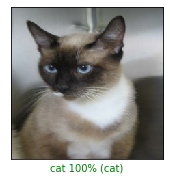

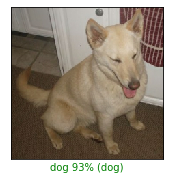

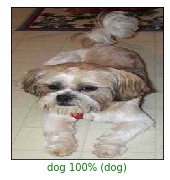

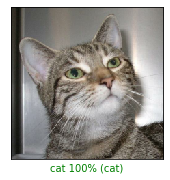

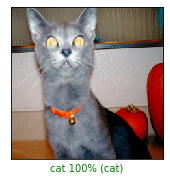

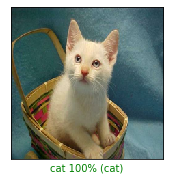

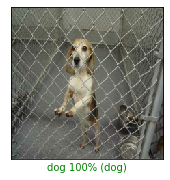

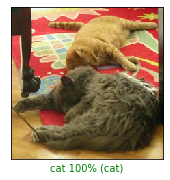

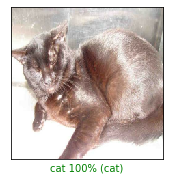

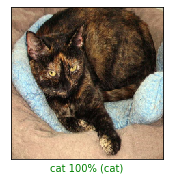

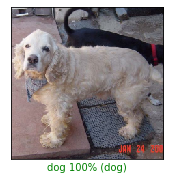

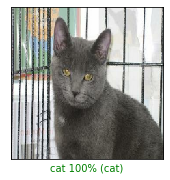

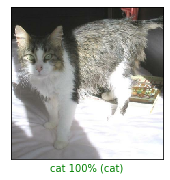

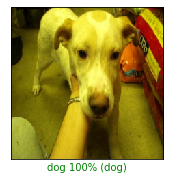

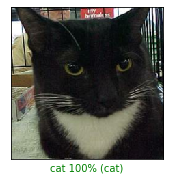

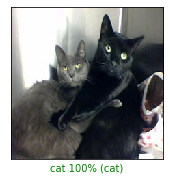

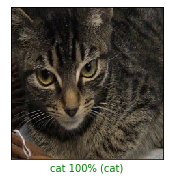

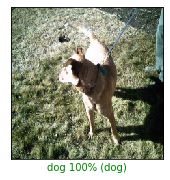

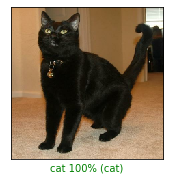

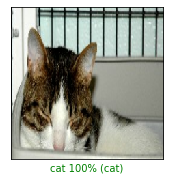

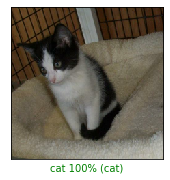

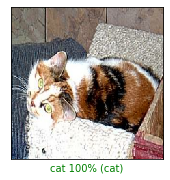

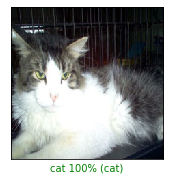

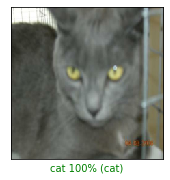

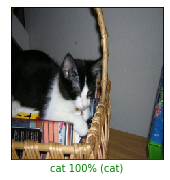

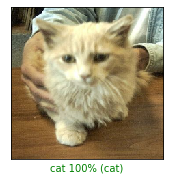

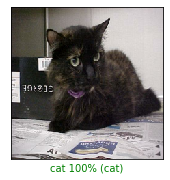

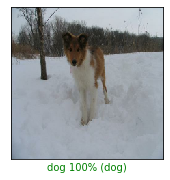

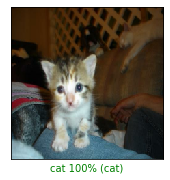

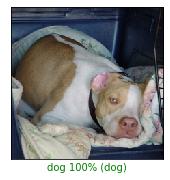

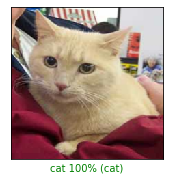

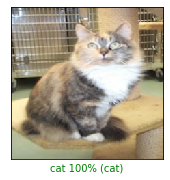

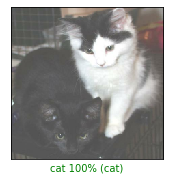

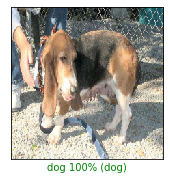

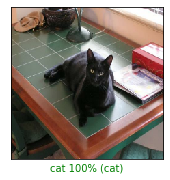

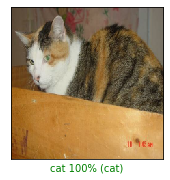

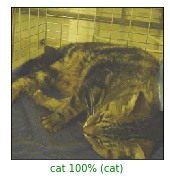

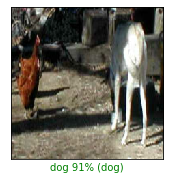

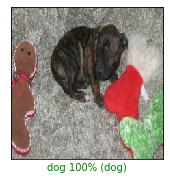

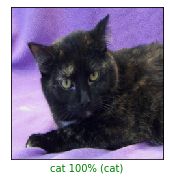

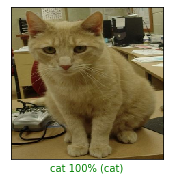

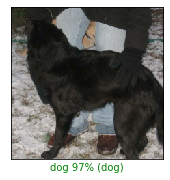

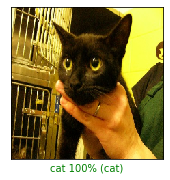

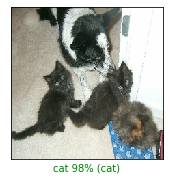

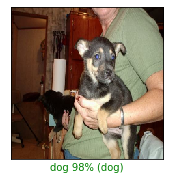

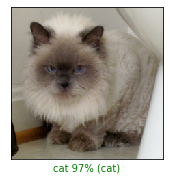

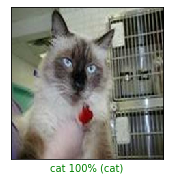

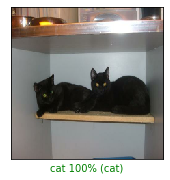

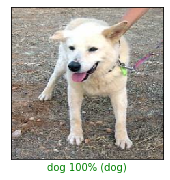

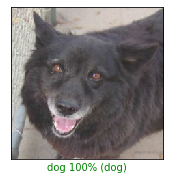

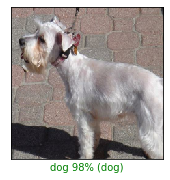

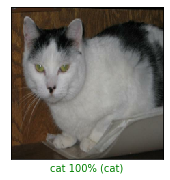

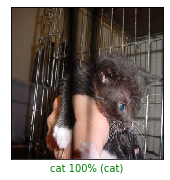

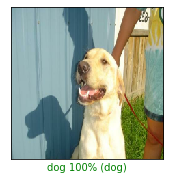

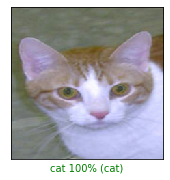

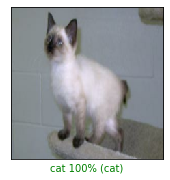

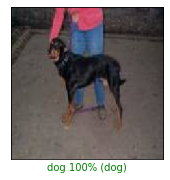

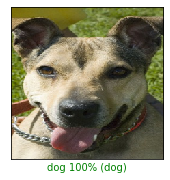

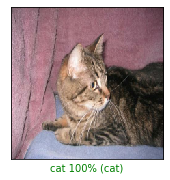

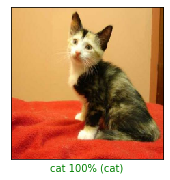

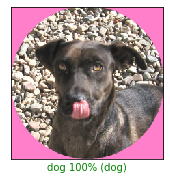

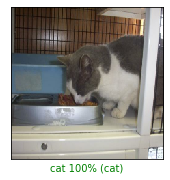

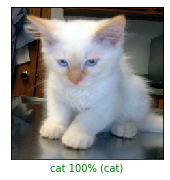

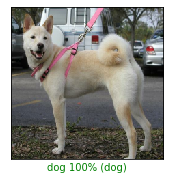

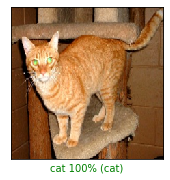

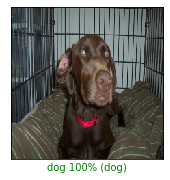

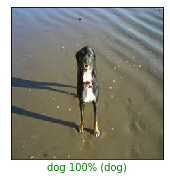

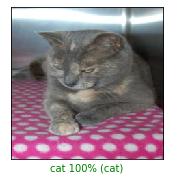

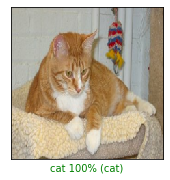

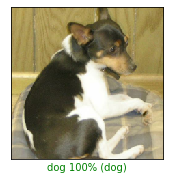

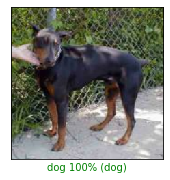

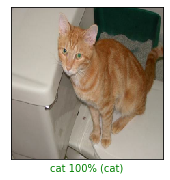

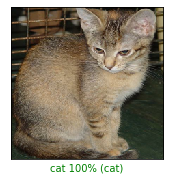

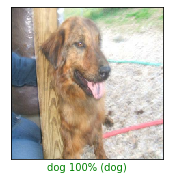

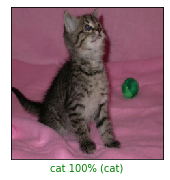

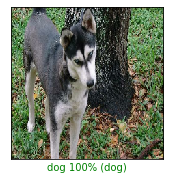

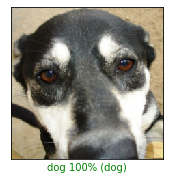

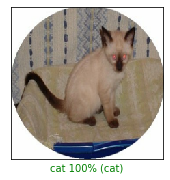

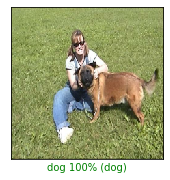

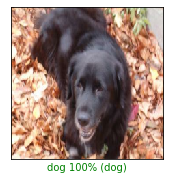

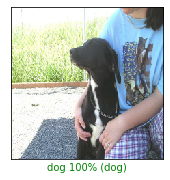

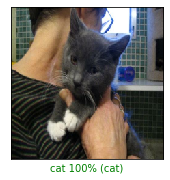

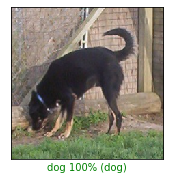

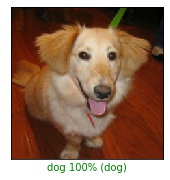

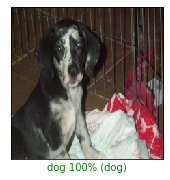

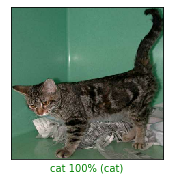

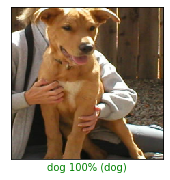

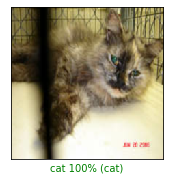

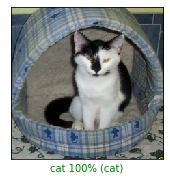

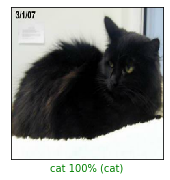

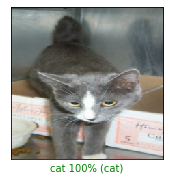

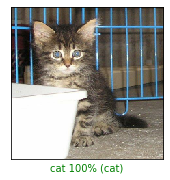

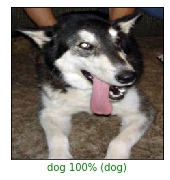

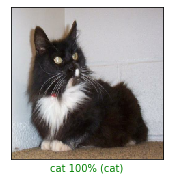

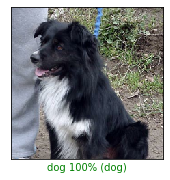

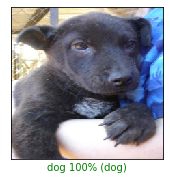

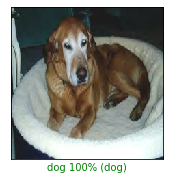

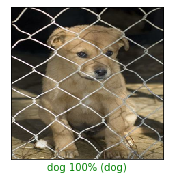

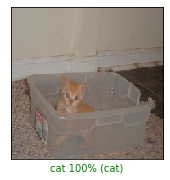

In [14]:
for index in range(0,99):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(index, predictions, test_labels, test_imgs)
    plt.show()

## Further study

To learn more about post-training quantization and optimization, please check out the user guides at https://www.tensorflow.org/lite/performance/post_training_quantization